In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.optimizers import RMSprop

WINDOW_SIZE = 5
SEQUENCE_LENGTH = 1
N_FEATURES = 6
N_EPOCHS = 100

# Load data
raw = pd.read_csv('sales_train.csv')
raw['date'] = pd.to_datetime(raw['date'], format='%d.%m.%Y')
raw = raw.sort_values(by=['date']).groupby(['date']).sum()['item_cnt_day'].to_frame()



Using TensorFlow backend.


Feature Engineering

In [2]:
raw['month']=raw.index.month
raw['day']=raw.index.day
raw['year']=raw.index.year
raw['dow']=raw.index.dayofweek
raw = pd.get_dummies(raw, columns=['dow'])
raw['date']=raw.index

In [3]:
data = pd.read_csv('sales_train.csv')
data['date'] = pd.to_datetime(data['date'], format='%d.%m.%Y')

In [4]:
gb = data.groupby(['date'], as_index=True).agg(
    {'item_cnt_day':{'item_target':'sum', 
                     'item_target_std': np.std,
                     'item_count_days': 'count'},
     'item_price':{'item_price_med':np.median, 
                   'item_price_mean': np.mean,
                   'item_price_std': np.std},
    })
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 
gb['date']=gb.index

In [5]:
all_data = pd.merge(raw,gb)
all_data.index = all_data['date']
all_data= all_data.drop(['item_target','date'],axis=1)

In [6]:
y_train=all_data['2013-01':'2015-09']['item_cnt_day']
y_test=all_data['2015-09':'2015-10']['item_cnt_day']
all_data_without=all_data.drop(['item_cnt_day'],axis=1)
x_train=all_data_without['2013-01':'2015-09']
x_test=all_data_without['2015-09':'2015-10']
train = all_data['2013-01':'2015-09']
test =all_data['2015-10']

scale data

In [7]:
x_scaler = MinMaxScaler().fit(all_data['item_cnt_day'].reshape(-1, 1))
train_y = x_scaler.transform(y_train.reshape(-1, 1)).reshape(-1,)
test_y = x_scaler.transform(y_test.reshape(-1, 1)).reshape(-1,)



In [8]:
col=['item_target_std', 'item_count_days',
       'item_price_med', 'item_price_mean', 'item_price_std']
train_x=x_train
test_x=x_test
for c in col:
    train_x[c] = x_scaler.transform(x_train[c].reshape(1, -1)).reshape(-1,)
    test_x[c] = x_scaler.transform(x_test[c].reshape(1, -1)).reshape(-1,)

In [9]:
train_x=np.array(train_x).reshape(1003,15,1)

In [10]:
model = Sequential()
model.add(LSTM(8, input_shape=train_x[0].shape))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Train
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
model.compile(loss='mean_squared_error',
              optimizer=optimizer,
              metrics=['mae'])

model.fit(train_x, train_y, batch_size=16, epochs=N_EPOCHS, verbose=2)

Epoch 1/100
 - 2s - loss: 0.0676 - mean_absolute_error: 0.2320
Epoch 2/100
 - 1s - loss: 0.0268 - mean_absolute_error: 0.1254
Epoch 3/100
 - 1s - loss: 0.0248 - mean_absolute_error: 0.1188
Epoch 4/100
 - 1s - loss: 0.0234 - mean_absolute_error: 0.1147
Epoch 5/100
 - 1s - loss: 0.0230 - mean_absolute_error: 0.1153
Epoch 6/100
 - 1s - loss: 0.0216 - mean_absolute_error: 0.1095
Epoch 7/100
 - 1s - loss: 0.0208 - mean_absolute_error: 0.1097
Epoch 8/100
 - 1s - loss: 0.0204 - mean_absolute_error: 0.1081
Epoch 9/100
 - 1s - loss: 0.0193 - mean_absolute_error: 0.1032
Epoch 10/100
 - 1s - loss: 0.0197 - mean_absolute_error: 0.1047
Epoch 11/100
 - 1s - loss: 0.0187 - mean_absolute_error: 0.1033
Epoch 12/100
 - 1s - loss: 0.0174 - mean_absolute_error: 0.0973
Epoch 13/100
 - 1s - loss: 0.0170 - mean_absolute_error: 0.0945
Epoch 14/100
 - 1s - loss: 0.0166 - mean_absolute_error: 0.0924
Epoch 15/100
 - 1s - loss: 0.0157 - mean_absolute_error: 0.0913
Epoch 16/100
 - 1s - loss: 0.0145 - mean_absolute

In [11]:
y_pred = model.predict(np.array(test_x).reshape(-1,15,1))

In [12]:
test_pred = x_scaler.inverse_transform(y_pred.reshape(1, -1)).reshape(-1,)

In [13]:
test_true = x_scaler.inverse_transform(test_y.reshape(1, -1)).reshape(-1,)

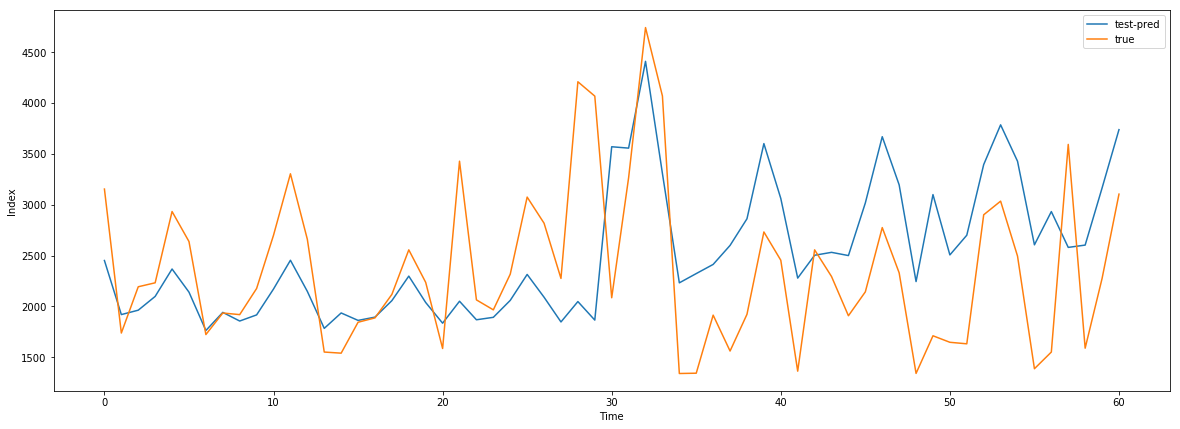

In [14]:
plt.figure(figsize=(20, 7))
plt.xlabel('Time')
plt.ylabel('Index')
plt.plot(test_pred, label='test-pred')
plt.plot(test_true, label='true')
plt.legend()
plt.show()

In [15]:
test_MSE=np.mean((test_true- test_pred)**2)
test_MSE

660312.2206708777

In [16]:
train_pred = model.predict(np.array(train_x).reshape(-1,15,1))


In [17]:
train_pred=x_scaler.inverse_transform(train_pred.reshape(1, -1)).reshape(-1,)
train_true =x_scaler.inverse_transform(train_y.reshape(1, -1)).reshape(-1,)

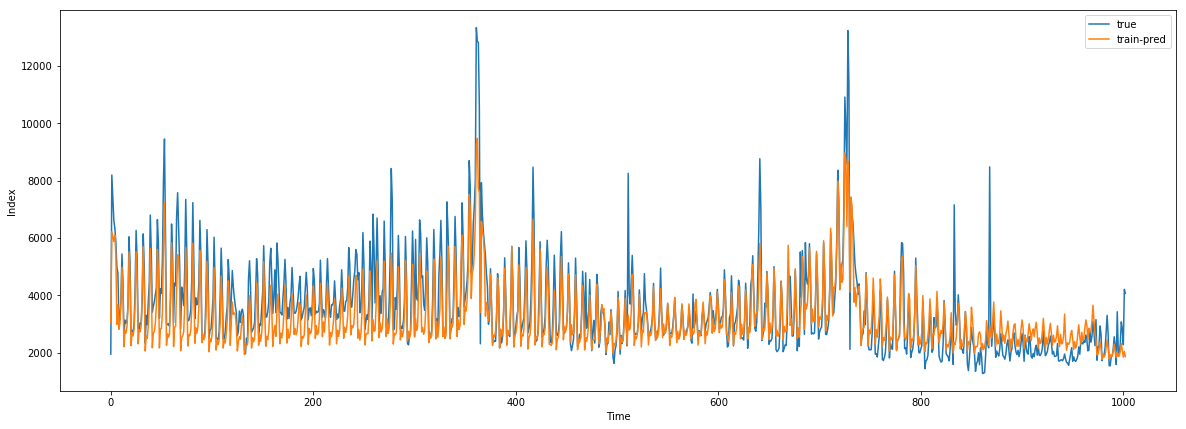

In [18]:
plt.figure(figsize=(20, 7))
plt.xlabel('Time')
plt.ylabel('Index')

plt.plot(train_true, label='true')
plt.plot(train_pred, label='train-pred')
plt.legend()
plt.show()

In [19]:
train_MSE=np.mean((train_true- train_pred)**2)
train_MSE

721888.9565119256